In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
domI = 0
domE = 3 * np.pi
numPoints = 100
x = np.linspace(domI, domE, numPoints)

def Sine(a,b,t):
    """a is the phase, b is the frequency"""
    return np.sin(a+b*np.pi*t)

In [3]:
def genSine(t,n):
    for i in range(n):
        a,b = np.random.randn(2)
        yield Sine(a,b,t)   

In [4]:
gen = genSine(x,100000)

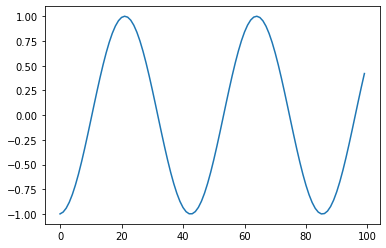

In [5]:
s0 = next(gen)
plt.plot(s0)

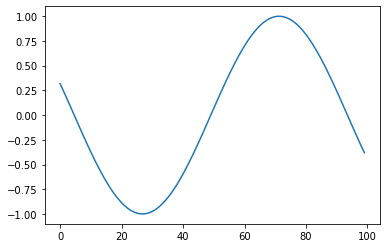

In [6]:
s1 = next(gen)
plt.plot(s1)

In [7]:
sineData = tf.data.Dataset.from_generator(genSine, args=[x,25000], output_types=tf.float32, output_shapes = (100,) )

In [8]:
it0 = iter(sineData)

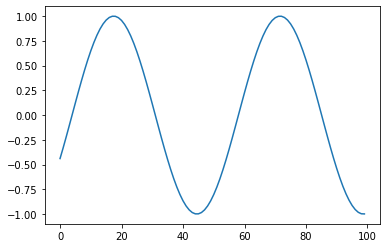

In [9]:
grap = next(it0)
plt.plot(grap)

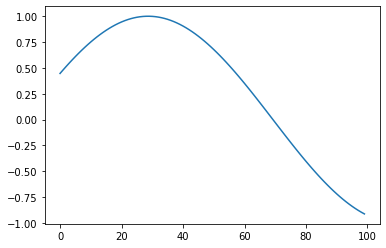

In [10]:
plt.plot(next(it0))

In [11]:
traintargDataset = sineData.map(lambda x: (x[:90],x[90:]))

In [12]:
it1 = iter(traintargDataset)

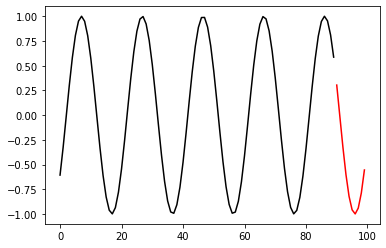

In [13]:
inp,targ = next(it1)
plt.plot(np.arange(90),inp,'k',90+np.arange(10),targ,'r')

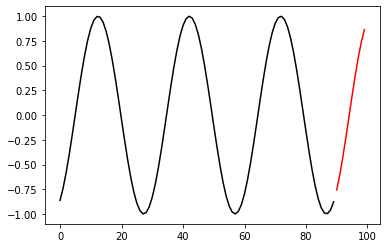

In [14]:
inp,targ = next(it1)
plt.plot(np.arange(90),inp,'k',90+np.arange(10),targ,'r')

# Prediction with a Linear Model

In [15]:
inputs = tf.keras.Input(shape=(90,))
outputs = tf.keras.layers.Dense(10)(inputs)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [16]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='MSE')

Let's create a **validation dataset** in the same way we created the train dataset

In [17]:
valsineData = tf.data.Dataset.from_generator(genSine, args=[x,2500],
                                             output_types=tf.float32, output_shapes = (100,) )
valDataset = valsineData.map(lambda x: (x[:90],x[90:]))

In [18]:
model.fit(traintargDataset.batch(32), epochs=10,validation_data=valDataset.batch(32))

Epoch 1/10
782/782 [==============================] - 2s 3ms/step - loss: 0.4714 - val_loss: 0.3725
Epoch 2/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3611 - val_loss: 0.3601
Epoch 3/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3495 - val_loss: 0.3374
Epoch 4/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3447 - val_loss: 0.3355
Epoch 5/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3344 - val_loss: 0.3373
Epoch 6/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3307 - val_loss: 0.3287
Epoch 7/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3284 - val_loss: 0.3445
Epoch 8/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3262 - val_loss: 0.3209
Epoch 9/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3216 - val_loss: 0.3204
Epoch 10/10
782/782 [==============================] - 2s 3ms/step - loss: 0.3243 - val_loss: 0.3313

# Prediction with a Recurrent Neural network

Let's  a recurrent  network that gets a sinus segment (10 samples) at each timestep and predicts the next timestep segment.

The first 90 samples of the 100 samples long segment will be divided in 9 segments and used as input data. The last 90 samples of the 100 samples long segment will be divided in 9 segments and used as targets.

Our train and validation Dataset will be slithly diffrent from the one we used in the linear model.

In [42]:
trainingDataset = sineData.map(lambda x: tf.reshape(x,(10,10)))
trainingDataset = trainingDataset.map(lambda x: (x[:9,:], x[1:,:]))

validationDataset = valsineData.map(lambda x: tf.reshape(x,(10,10)))
validationDataset = validationDataset.map(lambda x: (x[:9,:], x[1:,:]))

**Inputs to a recurrent network must have the shape (batch_size, sequence_length, ninputs_timestep)**





In [20]:
it2 = iter(trainingDataset)
inps, targs = next(it2)
print(inps.shape)
print(inps.shape)

(9, 10)
(9, 10)


We are just decomposing the long segment in the several segments

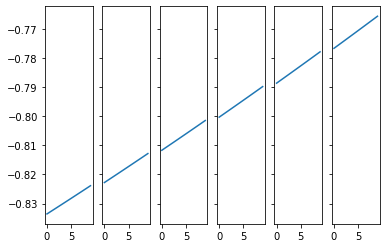

In [30]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, sharey='row')
ax1.plot(inps[0])
ax2.plot(inps[1])
ax3.plot(inps[2])
ax4.plot(inps[3])
ax5.plot(inps[4])
ax6.plot(inps[5])

Remark that each timestep targs segment corresponds to previous timestep inps segments 

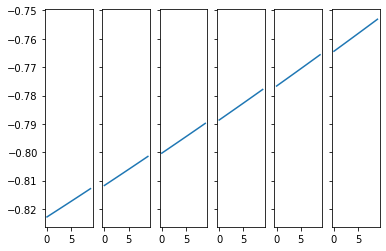

In [31]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(1,6, sharey='row')
ax1.plot(targs[0,:])
ax2.plot(targs[1,:])
ax3.plot(targs[2,:])
ax4.plot(targs[3,:])
ax5.plot(targs[4,:])
ax6.plot(targs[5,:])

## Our recurrent network model

We will use lstm units but you can replace them by any recurrent network type of units

In [35]:
inputs = tf.keras.Input(shape=(9,10))
#seq = tf.keras.layers.Reshape((9,10))(inputs)
lstm = tf.keras.layers.LSTM(20, return_sequences=True)(inputs)
outs = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10))(lstm)
recModel = tf.keras.Model(inputs=inputs, outputs=outs)

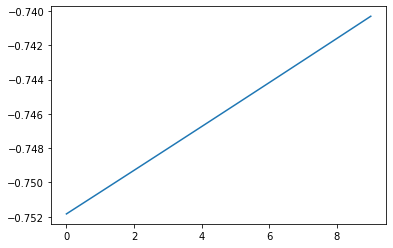

In [36]:
plt.plot(targs[6])

In [37]:
recModel.compile(optimizer=tf.keras.optimizers.RMSprop(),loss='MSE')

In [43]:
recModel.fit(trainingDataset.batch(32), epochs=10,validation_data=validationDataset.batch(32))

Epoch 1/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0056 - val_loss: 0.0048
Epoch 2/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 3/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0044 - val_loss: 0.0048
Epoch 4/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0042 - val_loss: 0.0039
Epoch 5/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0039 - val_loss: 0.0035
Epoch 6/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0037 - val_loss: 0.0030
Epoch 7/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0032 - val_loss: 0.0033
Epoch 8/10
782/782 [==============================] - 3s 3ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 9/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 10/10
782/782 [==============================] - 3s 4ms/step - loss: 0.0026 - val_loss: 0.0026

In [44]:
newiterator = iter(validationDataset.batch(2))
inputs, targets = next(newiterator)

In [45]:
preds = recModel.predict(inputs)

In [47]:
targetsf = np.reshape(targets,(2,90))
predf = np.reshape(preds,(2,90))
t=np.arange(90)

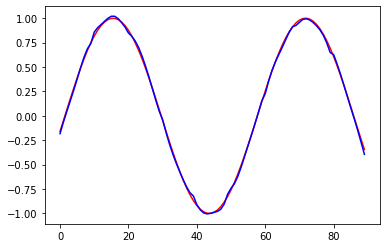

In [48]:
plt.plot(t,targetsf[0],'r',t,predf[0],'b')

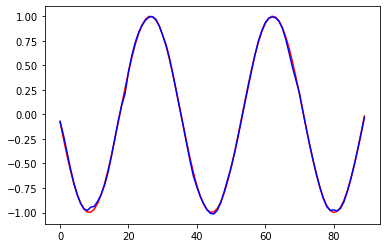

In [49]:
plt.plot(t,targetsf[1],'r',t,predf[1],'b')